In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
from tqdm import tqdm
import utils
import pickle
import random

In [2]:
with open('graph_objects/scigrid.pkl', 'rb') as f:
    G = pickle.load(f)
    G.name = 'SciGrid'

### Add country nodes to the grid, direct dead-end flow to country super nodes

In [3]:
def add_country_node_abstraction(G):
    G_with_country_nodes = G.copy()

    country_positions = {}

    for node_id, node_data in G_with_country_nodes.nodes(data=True):
        country_code = node_data.get('country_code')
        if country_code is not None:
            country_code = str.strip(country_code.upper())
        
        if country_code not in country_positions:
            country_positions[country_code] = []
        country_positions[country_code].append(node_data['pos'])

    for country_code, positions in country_positions.items():
        average_position = np.mean(positions, axis=0)
        G_with_country_nodes.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

    for node_id, node_data in G_with_country_nodes.nodes(data=True):
        if 'country_node' in node_data:
            G_with_country_nodes.remove_node(node_id)

    # Get the list of country nodes
    country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]

    # Iterate over each node in the graph
    for node_id, node_data in G_with_country_nodes.nodes(data=True):
        # Skip country nodes
        if node_data.get('is_country_node'):
            continue
        
        # Get the country code of the node
        country_code = node_data.get('country_code')
        
        # Find the corresponding country super node
        country_super_node = next((cn for cn in country_nodes if G_with_country_nodes.nodes[cn]['country_code'] == country_code), None)
        
        if country_super_node:
            # Check if the node is a sink (only incoming edges)
            if G_with_country_nodes.in_degree(node_id) > 0 and G_with_country_nodes.out_degree(node_id) == 0:
                # Calculate the aggregate in-degree capacity of the child node
                aggregate_in_capacity = sum(G_with_country_nodes.edges[neighbor, node_id]['capacity'] for neighbor in G_with_country_nodes.predecessors(node_id))
                
                # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
                G_with_country_nodes.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
            
            
            # Check if the node is a source (only outgoing edges)
            if G_with_country_nodes.in_degree(node_id) == 0 and G_with_country_nodes.out_degree(node_id) > 0:
                # Calculate the aggregate out-degree capacity of the child node
                aggregate_out_capacity = sum(G_with_country_nodes.edges[node_id, neighbor]['capacity'] for neighbor in G_with_country_nodes.successors(node_id))
                
                # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
                G_with_country_nodes.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 
    
    return G_with_country_nodes

G_with_country_nodes = add_country_node_abstraction(G)

### Visualize grid with country node abstractions

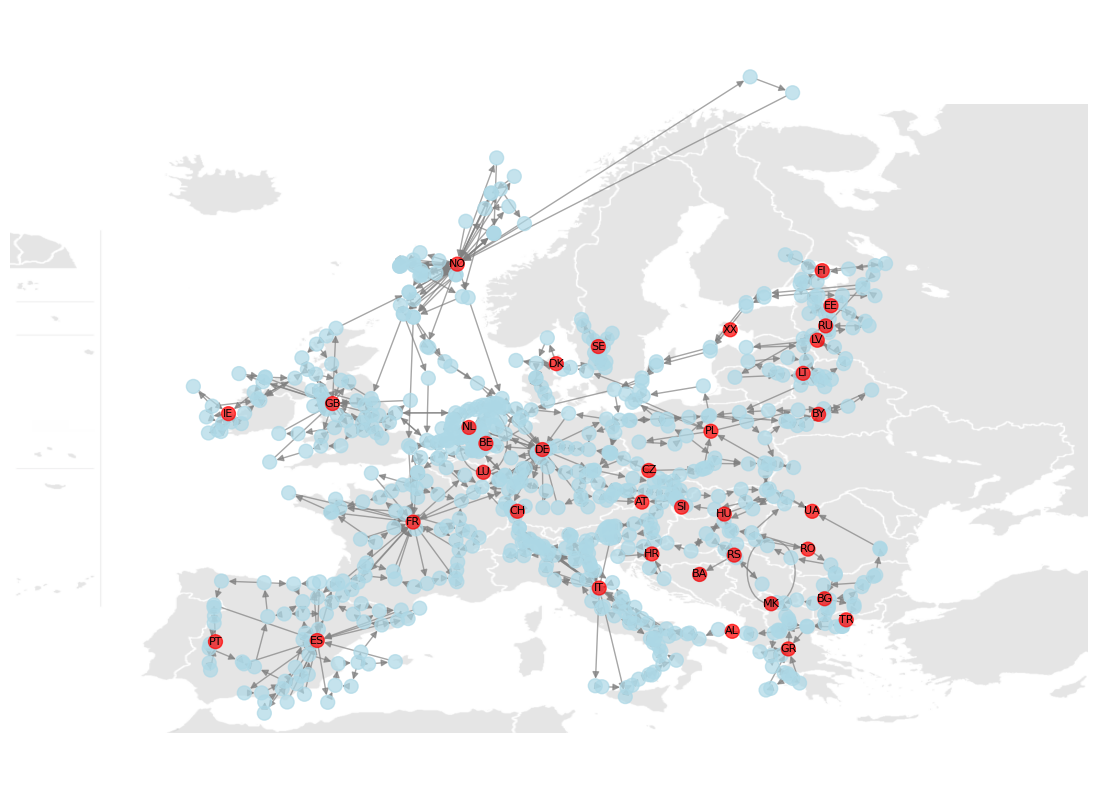

In [4]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G_with_country_nodes, 'pos')
node_colors = ['red' if G_with_country_nodes.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G_with_country_nodes.nodes]
nx.draw(G_with_country_nodes, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G_with_country_nodes, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

----
# Capacity robustness based on maximum flow.

In [5]:
def W(flow_dict):
    """ 
    Computes flow matrix W after running max flow algorithm on the graph.
    Defined in Cai et al. (2021) as the flow matrix of the network prior to any node removal.
    
    Returns:
        flow_matrix: 2D numpy array representing the flow matrix
        node_indices: Dictionary mapping nodes to their corresponding indices
    """
    nodes = list(flow_dict.keys())
    num_nodes = len(nodes)
    node_indices = {node: i for i, node in enumerate(nodes)}
    flow_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                flow_matrix[i, j] = flow_dict.get(nodes[i], {}).get(nodes[j], 0)
    
    return flow_matrix, node_indices


def W_c(flow_matrix, target, node_indices):
    """
    Computes the flow matrix W_c after removing a node.
    Defined in Cai et al. (2021) as the original flow matrix of the network after removing entry corresponding to the removed node.

    Parameters:
        flow_matrix: Flow matrix of the original graph
        target: Target can be either a single node or an edge in the form (v1, v2)
        node_indices: Dictionary mapping nodes to their indices in the flow matrix

    Returns:
        flow_matrix_c: Flow matrix after removing the specified node
        modified_flow_matrix: Modified flow matrix
    """

    modified_flow_matrix = np.copy(flow_matrix)

    if isinstance(target, (set,tuple)) and len(target) == 2:
        # Target is an edge in the form (v1, v2)
        v1, v2 = target
        index_v1 = node_indices.get(v1, None)
        index_v2 = node_indices.get(v2, None)

        if index_v1 is not None and index_v2 is not None:
            modified_flow_matrix[index_v1, index_v2] = 0
            modified_flow_matrix[index_v2, index_v1] = 0
    
    else:
        # Target is a single node
        removed_node_index = node_indices.get(target, None)

        # Exclude the row and column corresponding to the removed node
        if removed_node_index is not None and removed_node_index < modified_flow_matrix.shape[0]:
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=0)
            modified_flow_matrix = np.delete(modified_flow_matrix, removed_node_index, axis=1)

    return modified_flow_matrix

In [6]:
def flow_capacity_robustness(G_, sources, sinks, k_removals, heuristic='random', remove='node', n_benchmarks = 100, all_to_all_flow=False):
    """ 
    Computes the n-k capacity robustness based on maximum flow of a graph
    Defined in Cai et al. (2021) as: sum(W_c_prime) / sum(W_c)
    """

    # Make a copy of the graph
    G = G_.copy()

    # Remove the country node abstractions from the graph
    country_nodes = [n for n in G.nodes if G.nodes[n].get('is_country_node') and n not in sources and n not in sinks]
    G.remove_nodes_from(country_nodes)

    # If all_to_all_flow is True, remove all country nodes and instead use all nodes as sources and sinks
    if all_to_all_flow:
        G.remove_nodes_from([n for n in G.nodes if G.nodes[n].get('is_country_node')])
        sources = [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) > 0]
        sinks = [n for n in G.nodes() if G.out_degree(n) == 0 and G.in_degree(n) > 0]

    # Calculate the original flow matrix W of the graph
    flow_val, flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
    flow_matrix, node_indices = W(flow_dict)

    # Instantiate the results dataframe
    results_df = pd.DataFrame(columns=['max_flow_value', 'capacity_robustness_max_flow', 'heuristic', 'removed_entity', 'entity_data', 'sources', 'sinks', 'network_state', 'flow_dict', 'comment'])
    results_df.loc[0] = [flow_val, 1, None, None, None, sources, sinks, G.copy(), flow_dict, 'No removals made']

    # Helper function to check if a node is valid
    def node_is_valid(n, sources, sinks, g):
        return n not in sources and n not in sinks and n != 'super_source' and n != 'super_sink' and n in g.nodes()
    
    # Helper function to check if an edge is valid
    def edge_is_valid(src, snk, sources, sinks, g):
        return src not in sources and snk not in sinks and src != 'super_source' and snk != 'super_sink' and (src, snk) in g.edges() 
    
    # Helper function to remove a node from the graph
    def remove_node(G, edge, df):
        if edge[0] not in sources:
            target = edge[0]
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[1] not in sinks:
            target = edge[1]
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[0] in sources:
            target = edge[0]
            sources.remove(target)
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        elif edge[1] in sinks:
            target = edge[1]
            sinks.remove(target)
            target_data = G.nodes[target]
            G.remove_node(target)
            return target, target_data
        else:
            return df, None

    # Helper function to perform a targeted removal   
    def perform_targeted_removal(G, heuristic, target, flow_matrix, node_indices, results_df):
        if remove == 'edge':
                target_data = G.get_edge_data(*target)
                G.remove_edge(*target)
        else:
            target, target_data = remove_node(G, target, results_df)
            if isinstance(target, pd.DataFrame):
                return results_df
            
        # Calculate the flow matrix W_c after removing the node or edge
        flow_matrix = W_c(flow_matrix, target, node_indices)
        W_c_ = flow_matrix

        # Recompute W_c_prime (flow matrix) after the network has sustained damage
        current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)
        W_c_prime, _ = W(current_flow_dict)

        results_df.loc[k] = [current_max_flow_val, np.sum(W_c_prime) / np.sum(W_c_), heuristic, target, target_data, sources, sinks, G.copy(), current_flow_dict, None]
    
    # Heuristic specific initializations
    if heuristic == 'random':
        G_lst = [G.copy() for _ in range(n_benchmarks)]
        G_flow_matrix_lst = [flow_matrix for _ in range(n_benchmarks)]
    if heuristic == 'load_rate':
        edge_capacities = {edge: G.edges[edge]['capacity'] for edge in G.edges()}

    # N-k capacity robustness calculation
    for k in tqdm(range(1, k_removals + 1), desc='N-k capacity robustness'):

        if heuristic == 'random':
            max_flow_lst, capacity_robustness_lst = [], []

            for G_copy, G_flow_matrix in zip(G_lst, G_flow_matrix_lst):

                valid_targets = [target for target in (G_copy.nodes() if remove == 'node' else G_copy.edges()) if node_is_valid(target, sources, sinks, G_copy) or edge_is_valid(target[0], target[1], sources, sinks, G_copy)]
                target = random.choice(valid_targets)
                
                if remove == 'edge':
                    target_data = G_copy.get_edge_data(*target)
                    G_copy.remove_edge(*target)
                else:
                    target_data = G_copy.nodes[target]
                    G_copy.remove_node(target)

                G_flow_matrix = W_c(G_flow_matrix, target, node_indices)
                W_c_ = G_flow_matrix

                current_max_flow_val, current_flow_dict, _ = utils.max_flow(G_copy, sources, sinks, show_plot=False)
                W_c_prime, _ = W(current_flow_dict)

                capacity_robustness_lst.append(np.sum(W_c_prime) / np.sum(W_c_))
                max_flow_lst.append(current_max_flow_val)

            results_df.loc[k] = [np.mean(max_flow_lst), np.mean(capacity_robustness_lst), 'random', target, target_data, sources, sinks, G_copy.copy(), current_flow_dict,'Specimen graph, averaged across '+str(n_benchmarks)+' benchmarks']

        
        elif heuristic == 'load_rate':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)

            flow_edges = {(source, target): flow for source, targets in current_flow_dict.items() for target, flow in targets.items() if flow != 0}
            sorted_edge_loads = dict(sorted({edge: flow / edge_capacities[edge] for edge, flow in flow_edges.items() if edge in edge_capacities}.items(), key=lambda item: item[1], reverse=True))
            
            if len(sorted_edge_loads) == 0:
                return results_df
            
            target = list(sorted_edge_loads.keys())[0]
     
            perform_targeted_removal(G, 'congestion', target, flow_matrix, node_indices, results_df)
        

        elif heuristic == 'max_flow':
            current_max_flow_val, current_flow_dict, _ = utils.max_flow(G, sources, sinks, show_plot=False)

            # Find the edge that maximizes the flow
            max_flow, target = float('-inf'), None
            max_flow, target = max(((flow, (source, sink)) for source, edges in current_flow_dict.items() for sink, flow in edges.items() if edge_is_valid(source, sink, sources, sinks, G) and node_is_valid(source, sources, sinks, G) and flow > max_flow), key=lambda x: x[0], default=(float('-inf'), None))
    
            perform_targeted_removal(G, 'max_flow', target, flow_matrix, node_indices, results_df)

        
        # Other heuristics


        else:
            raise ValueError("Invalid heuristic")


    return results_df

In [7]:
n_benchmarks = 50

sources = ['NO', 'RU']
sinks = ['DE', 'FR']

----
# Greedy heuristics
- Max flow based
- Load-rate based
- Max flow edge count
- Min cutset count
- Weighted flow capacity rate
- ...

### Node removal ('sinks-to-sources')

In [8]:
# random_node_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_node_removal_df.to_pickle('results/random_node_removal_df.pkl')
random_node_removal_df = pd.read_pickle('results/random_node_removal_df.pkl')

In [9]:
# load_rate_node_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=100, heuristic='load_rate', remove='node', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# load_rate_node_removal_df.to_pickle('results/load_rate_node_removal_df.pkl')
load_rate_node_removal_df = pd.read_pickle('results/load_rate_node_removal_df.pkl')

In [10]:
# max_flow_node_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=150, heuristic='max_flow', remove='node', all_to_all_flow=True)
# max_flow_node_removal_df.to_pickle('results/max_flow_node_removal_df.pkl')
max_flow_node_removal_df = pd.read_pickle('results/max_flow_node_removal_df.pkl')


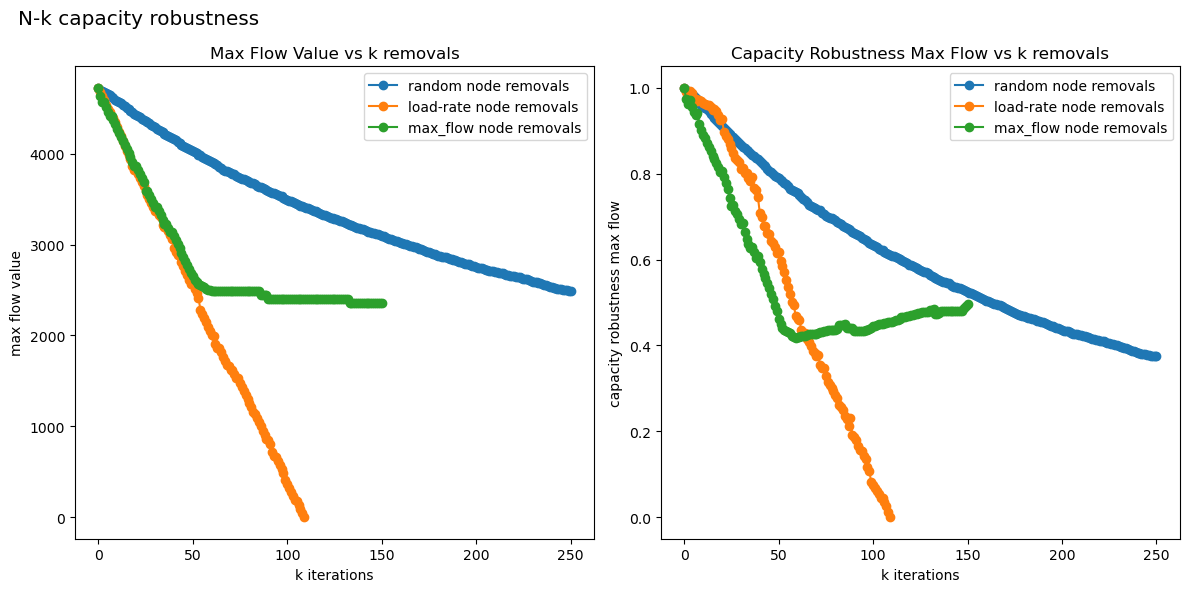

In [11]:
utils.plot_heuristic_comparison_biplot([random_node_removal_df, load_rate_node_removal_df, max_flow_node_removal_df], 'N-k capacity robustness')

### Node removal (case-specific)

In [12]:
# random_node_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='node', n_benchmarks=n_benchmarks)
# random_node_removal_geo_df.to_pickle('results/random_node_removal_geo_df.pkl')
random_node_removal_geo_df = pd.read_pickle('results/random_node_removal_geo_df.pkl')

In [13]:
# load_rate_node_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='load_rate', remove='node', n_benchmarks=n_benchmarks)
# load_rate_node_removal_geo_df.to_pickle('results/load_rate_node_removal_geo_df.pkl')
load_rate_node_removal_geo_df = pd.read_pickle('results/load_rate_node_removal_geo_df.pkl')

In [14]:
# max_flow_node_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='node')
# max_flow_node_removal_geo_df.to_pickle('results/max_flow_node_removal_geo_df.pkl')
max_flow_node_removal_geo_df = pd.read_pickle('results/max_flow_node_removal_geo_df.pkl')

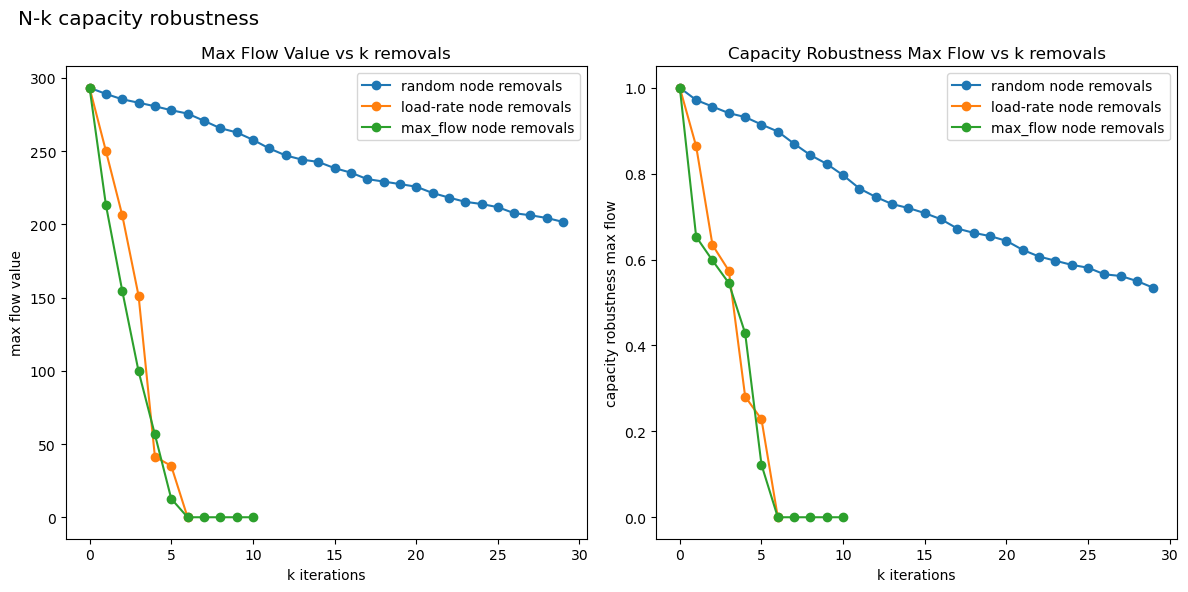

In [15]:
utils.plot_heuristic_comparison_biplot([random_node_removal_geo_df.head(30), load_rate_node_removal_geo_df, max_flow_node_removal_geo_df], 'N-k capacity robustness')

### Edge removal ('sinks-to-sources')

In [16]:
# random_edge_remova_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# random_edge_removal_df.to_pickle('results/random_edge_removal_df.pkl')
random_edge_removal_df = pd.read_pickle('results/random_edge_removal_df.pkl')

In [17]:
# load_rate_edge_removal_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='load_rate', remove='edge', n_benchmarks=n_benchmarks, all_to_all_flow=True)
# load_rate_edge_removal_df.to_pickle('results/load_rate_edge_removal_df.pkl')
load_rate_edge_removal_df = pd.read_pickle('results/load_rate_edge_removal_df.pkl')

In [18]:
# max_flow_edge_removall_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='max_flow', remove='edge', all_to_all_flow=True)
# max_flow_edge_removal_df.to_pickle('results/max_flow_edge_removal_df.pkl')
max_flow_edge_removal_df = pd.read_pickle('results/max_flow_edge_removal_df.pkl')

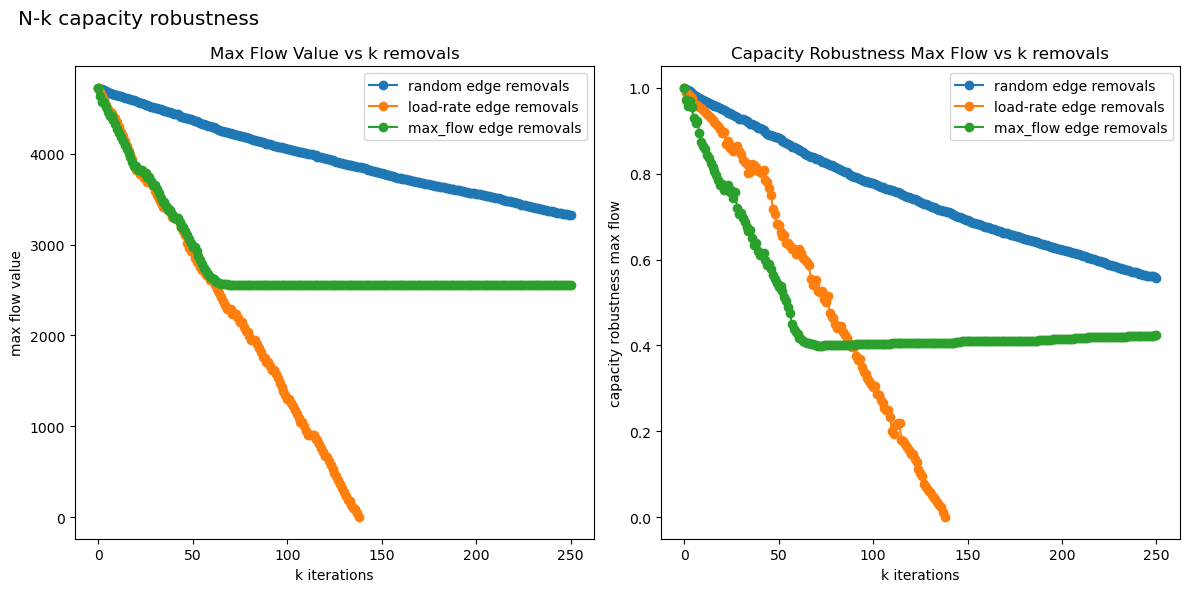

In [19]:
utils.plot_heuristic_comparison_biplot([random_edge_removal_df, load_rate_edge_removal_df, max_flow_edge_removal_df], 'N-k capacity robustness')

### Edge removal (case-specific)

In [20]:
# random_edge_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='random', remove='edge', n_benchmarks=n_benchmarks)
# random_edge_removal_geo_df.to_pickle('results/random_edge_removal_geo_df.pkl')
random_edge_removal_geo_df = pd.read_pickle('results/random_edge_removal_geo_df.pkl')

In [21]:
# load_rate_edge_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=250, heuristic='load_rate', remove='edge', n_benchmarks=n_benchmarks)
# load_rate_edge_removal_geo_df.to_pickle('results/load_rate_edge_removal_geo_df.pkl')
load_rate_edge_removal_geo_df = pd.read_pickle('results/load_rate_edge_removal_geo_df.pkl')

In [22]:
# max_flow_edge_removal_geo_df = flow_capacity_robustness(G_with_country_nodes, sources, sinks, k_removals=10, heuristic='max_flow', remove='edge')
# max_flow_edge_removal_geo_df.to_pickle('results/max_flow_edge_removal_geo_df.pkl')
max_flow_edge_removal_geo_df = pd.read_pickle('results/max_flow_edge_removal_geo_df.pkl')

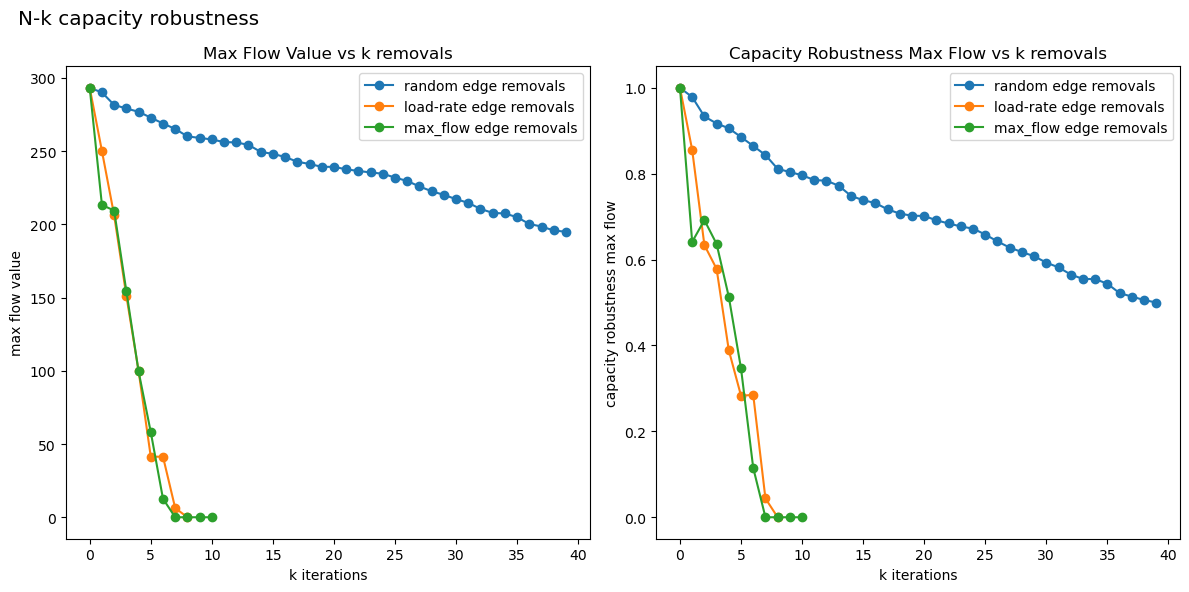

In [23]:
utils.plot_heuristic_comparison_biplot([random_edge_removal_geo_df.head(40), load_rate_edge_removal_geo_df, max_flow_edge_removal_geo_df], 'N-k capacity robustness')

----
# Iterative visualization of flow capacity robustness

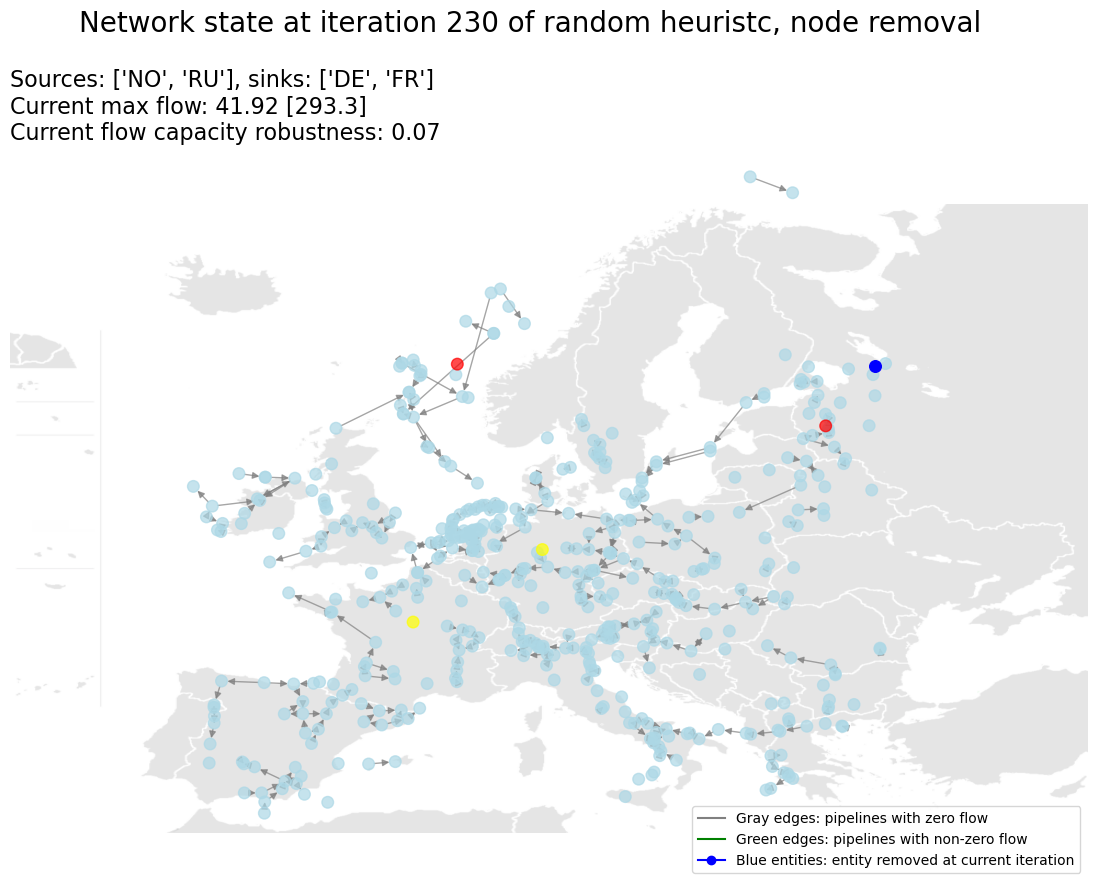

In [24]:
utils.visualize_network_state(random_node_removal_geo_df, iteration=230, only_flow_edges=False)

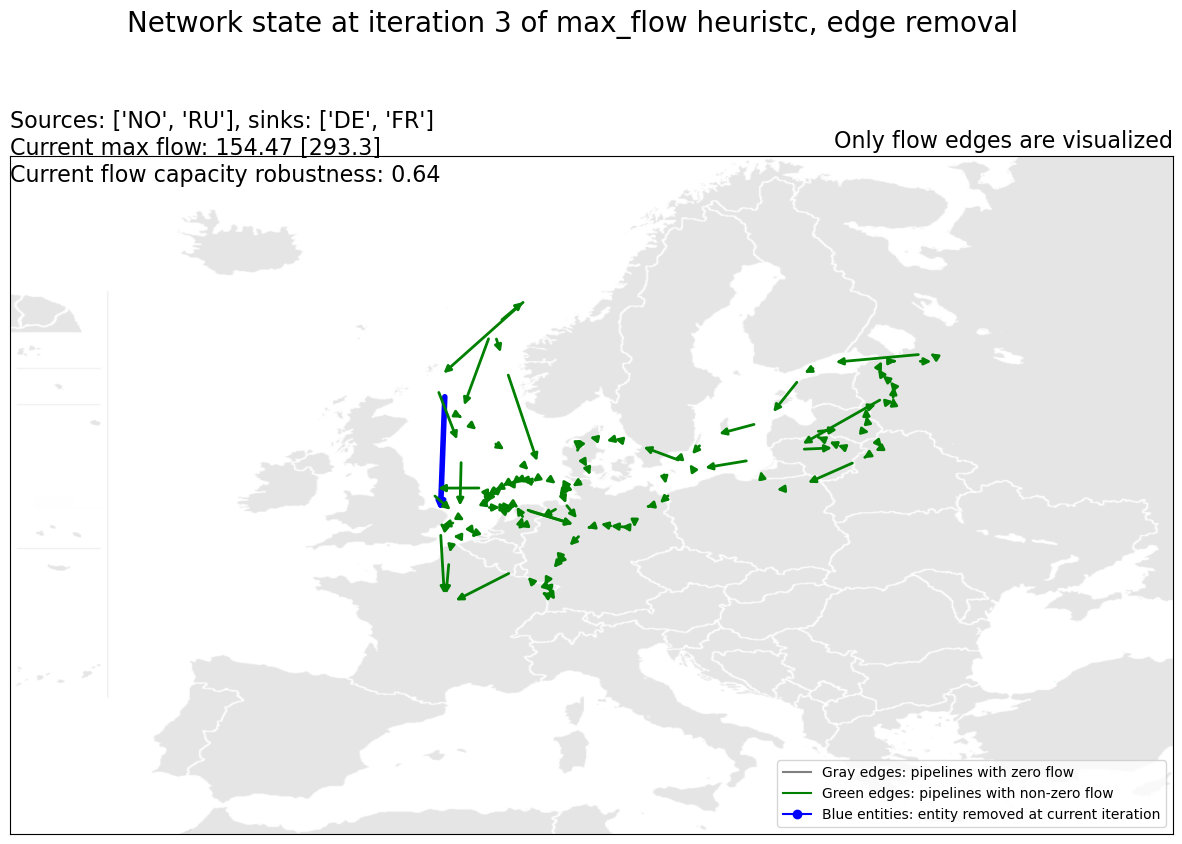

In [25]:
utils.visualize_network_state(max_flow_edge_removal_geo_df, iteration=3, only_flow_edges=True)

----
# Flow recovery (Cai et al., 2021)

### Flow recovery pseudo-code

    Program Network Recovery
        For vj in Vs
            For vi in Vd
                If is Adjacent (vi, vj)  True
                    add node vi to network G
                    add edge {vi, vj} to network G
                End If
            End For
        End For
    End Network Recovery

vj and ni are adjacent nodes. Vd set of damaged nodes. Vs set of remaining nodes after n-k.

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def flow_recovery(results_df_, plot_recovery=True):
    """
    Run the recovery algorithm on the network.
    """

    # Copy the results dataframe
    results_df = results_df_.copy()

    # Instantiate the recovery (results) dataframe
    recovery_df = pd.DataFrame(columns=['damage_rate', 'flow_recovery', 'flow_improvement_rate', 'recovered_grid_size'])

    # Helper function to recover the network
    def recover(df_, iteration):
        """
        Flow recovery algorithm to recover the network after damage.
        Defined in Cai et al. (2021).  
        """

        df = df_.copy()

        damaged_network = df.loc[iteration, 'network_state'].copy()
        undamaged_network = df.loc[0, 'network_state'].copy()

        # Set of remaining nodes
        Vs = list(damaged_network.nodes())

        # Set of damanged (removed) nodes
        Vd = list(undamaged_network.nodes() - damaged_network.nodes())

        reinstated_nodes = []

        # Flow recovery
        # First, add nodes to reinstate network structure
        for vj in Vs:
            for vi in Vd:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_node(vi, pos=undamaged_network.nodes[vi]['pos'], is_country_node=False, recovered_entity=True)
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
                    reinstated_nodes.append(vi)

        # Add edges between set of reinstated nodes
        for vi in reinstated_nodes:
            for vj in reinstated_nodes:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)
        
        # Add edges between reinstated nodes and (previously) remaining nodes
        for vi in reinstated_nodes:
            for vj in Vs:
                if (vi, vj) in undamaged_network.edges():
                    damaged_network.add_edge(vi, vj, capacity=undamaged_network[vi][vj]['capacity'], recovered_entity=True)
                if (vj, vi) in undamaged_network.edges():
                    damaged_network.add_edge(vj, vi, capacity=undamaged_network[vj][vi]['capacity'], recovered_entity=True)

        # Damaged network now undergone recovery
        recovered_network = damaged_network

        damaged_flow_val = df.loc[iteration, 'max_flow_value']
        recovered_flow_val, _, _ = utils.max_flow(recovered_network, df.loc[0, 'sources'], df.loc[0, 'sinks'], show_plot=False)

        return df.loc[0, 'max_flow_value'], damaged_flow_val, recovered_flow_val, recovered_network

    init_num_nodes = results_df.loc[0, 'network_state'].number_of_nodes()

    for i in tqdm(range(1, results_df.shape[0]), desc='Recovery process'):
        optimal_max_flow, damaged_flow_val, recovered_flow_val, recovered_network = recover(results_df, iteration=i)

        damage_rate = 1 - results_df.loc[i, 'network_state'].number_of_nodes() / init_num_nodes
        flow_recovery = recovered_flow_val / optimal_max_flow
        flow_improvement_rate = None if damaged_flow_val == 0 else sigmoid(recovered_flow_val/damaged_flow_val)
        recovered_grid_size = recovered_network.number_of_nodes() / init_num_nodes

        recovery_df.loc[i] = [damage_rate, flow_recovery, flow_improvement_rate, recovered_grid_size]

    if plot_recovery:
        reversed_recovery_df = recovery_df.iloc[::-1].reset_index(drop=True)

        plt.figure(figsize=(10, 6))
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_recovery'], label='flow recovery (relative to optimal)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['flow_improvement_rate'], label='flow improvement (relative to sub-optimal flow incurred by given grid damage)')
        plt.plot(reversed_recovery_df['damage_rate'], reversed_recovery_df['recovered_grid_size'], label='size of recovered grid (relative to initial grid size)')
        
        plt.xlabel('Grid damage rate (pct. nodes removed)')
        plt.ylabel('Recovery')
        plt.title('Flow recovery')

        # Reverse the x-axis scale
        plt.gca().invert_xaxis()

        plt.legend()
        plt.show()

    return recovery_df

### Node, random heuristic, all-to-all flow

In [27]:
# random_node_removal_all_to_all_recovery_df = flow_recovery(random_node_removal_all_to_all_df, plot_recovery=True)
# random_node_removal_all_to_all_recovery_df.to_pickle('results/random_node_removal_all_to_all_recovery_df.pkl')

random_node_removal_all_to_all_recovery_df = pd.read_pickle('results/random_node_removal_all_to_all_recovery_df.pkl')
random_node_removal_all_to_all_recovery_df

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001401,1.000000,0.731923,1.000000
2,0.002801,1.000000,0.732328,1.000000
3,0.004202,1.000000,0.732874,1.000000
4,0.005602,1.000000,0.733405,1.000000
5,0.007003,1.000000,0.733886,1.000000
...,...,...,...,...
246,0.344538,0.959854,0.859410,0.959384
247,0.345938,0.959854,0.859760,0.959384
248,0.347339,0.959854,0.860100,0.959384
249,0.348739,0.959854,0.860441,0.955182


### Node, random heuristic, geopolitical flow

In [28]:
# random_node_removal_geopolitical_recovery_df = flow_recovery(random_node_removal_geopolitical_df, plot_recovery=True)
# random_node_removal_geopolitical_recovery_df.to_pickle('results/random_node_removal_geopolitical_recovery_df.pkl')

random_node_removal_geopolitical_recovery_df = pd.read_pickle('results/random_node_removal_geopolitical_recovery_df.pkl')
random_node_removal_geopolitical_recovery_df

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001393,1.0,0.733872,1.000000
2,0.002786,1.0,0.736430,1.000000
3,0.004178,1.0,0.738067,1.000000
4,0.005571,1.0,0.739786,1.000000
5,0.006964,1.0,0.741743,1.000000
...,...,...,...,...
246,0.342618,1.0,0.999586,0.966574
247,0.344011,1.0,0.999586,0.966574
248,0.345404,1.0,0.999586,0.966574
249,0.346797,1.0,0.999586,0.965181


### Node, max_flow heuristic, all-to-all flow

In [29]:
# max_flow_node_removal_all_to_all_recovery_df = flow_recovery(max_flow_node_removal_all_to_all_df, plot_recovery=True)
# max_flow_node_removal_all_to_all_recovery_df.to_pickle('results/max_flow_node_removal_all_to_all_recovery_df.pkl')

max_flow_node_removal_all_to_all_recovery_df = pd.read_pickle('results/max_flow_node_removal_all_to_all_recovery_df.pkl')
max_flow_node_removal_all_to_all_recovery_df

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001401,1.000000,0.734877,1.000000
2,0.002801,1.000000,0.737486,1.000000
3,0.004202,1.000000,0.737743,1.000000
4,0.005602,1.000000,0.740165,1.000000
5,0.007003,1.000000,0.742631,1.000000
...,...,...,...,...
146,0.204482,0.982655,0.877758,0.994398
147,0.205882,0.982655,0.877758,0.994398
148,0.207283,0.982655,0.877758,0.992997
149,0.208683,0.982655,0.877758,0.992997


### Node, max flow heuristic, geopolitical flow

In [30]:
# max_flow_node_removal_geopolitical_recovery_df = flow_recovery(max_flow_node_removal_geopolitical_df, plot_recovery=True)
# max_flow_node_removal_geopolitical_recovery_df.to_pickle('results/max_flow_node_removal_geopolitical_recovery_df.pkl')

max_flow_node_removal_geopolitical_recovery_df = pd.read_pickle('results/max_flow_node_removal_geopolitical_recovery_df.pkl')
max_flow_node_removal_geopolitical_recovery_df

,damage_rate,flow_recovery,flow_improvement_rate,recovered_grid_size
1,0.001393,1.0,0.798196,1.0
2,0.002786,1.0,0.869471,1.0
3,0.004178,1.0,0.949916,1.0
4,0.005571,1.0,0.994450,1.0
5,0.006964,1.0,1.000000,1.0
6,0.008357,1.0,NaN,1.0
7,0.009749,1.0,NaN,1.0
8,0.011142,1.0,NaN,1.0
9,0.012535,1.0,NaN,1.0
10,0.013928,1.0,NaN,1.0
